### Description of notebook

In this notebook, I implement Deep Successor Reinforcement Learning by Tejas D. Kulkarni, Ardavan Saeedi, Simanta Gautam, Samuel J. Gershman. ([link](https://arxiv.org/abs/1606.02396))

v6 - code doesn't work very well! results for a 4x4 grid.

To do:
- include visdom for visualization

### Loading required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import gym
import math
import random
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from skimage.transform import resize

### Testing the environment

In [2]:
from gym_minigrid.register import env_list
from gym_minigrid.minigrid import Grid, OBJECT_TO_IDX

# Test specifically importing a specific environment
from gym_minigrid.envs import DoorKeyEnv

# Test importing wrappers
from gym_minigrid.wrappers import *

def test_minigrid():
    """
    Function to test if the minigrid environments are loaded properly
    """

    ##############################################################################

    print('%d environments registered' % len(env_list))

    for env_name in env_list:
        print('testing "%s"' % env_name)

        # Load the gym environment
        env = gym.make(env_name)
        env.max_steps = min(env.max_steps, 200)
        env.reset()
        env.render('rgb_array')

        # Verify that the same seed always produces the same environment
        for i in range(0, 5):
            seed = 1337 + i
            env.seed(seed)
            grid1 = env.grid
            env.seed(seed)
            grid2 = env.grid
            assert grid1 == grid2

        env.reset()

        break

        # Run for a few episodes
        num_episodes = 0
        while num_episodes < 5:
            # Pick a random action
            action = random.randint(0, env.action_space.n - 1)

            obs, reward, done, info = env.step(action)

            # Validate the agent position
            assert env.agent_pos[0] < env.width
            assert env.agent_pos[1] < env.height

            # Test observation encode/decode roundtrip
            img = obs['image']
            vis_mask = img[:, :, 0] != OBJECT_TO_IDX['unseen']  # hackish
            img2 = Grid.decode(img).encode(vis_mask=vis_mask)
            assert np.array_equal(img, img2)

            # Test the env to string function
            str(env)

            # Check that the reward is within the specified range
            assert reward >= env.reward_range[0], reward
            assert reward <= env.reward_range[1], reward

            if done:
                num_episodes += 1
                env.reset()

            env.render('rgb_array')
            break

        # Test the close method
        env.close()

        env = gym.make(env_name)
        env = ReseedWrapper(env)
        for _ in range(10):
            env.reset()
            env.step(0)
            env.close()

        env = gym.make(env_name)
        env = ImgObsWrapper(env)
        env.reset()
        env.step(0)
        env.close()

        # Test the fully observable wrapper
        env = gym.make(env_name)
        env = FullyObsWrapper(env)
        env.reset()
        obs, _, _, _ = env.step(0)
        assert obs.shape == env.observation_space.shape
        env.close()

        env = gym.make(env_name)
        env = FlatObsWrapper(env)
        env.reset()
        env.step(0)
        env.close()

        env = gym.make(env_name)
        env = AgentViewWrapper(env, 5)
        env.reset()
        env.step(0)
        env.close()

    ##############################################################################

    print('testing agent_sees method')
    env = gym.make('MiniGrid-DoorKey-6x6-v0')
    goal_pos = (env.grid.width - 2, env.grid.height - 2)

    # Test the "in" operator on grid objects
    assert ('green', 'goal') in env.grid
    assert ('blue', 'key') not in env.grid

    # Test the env.agent_sees() function
    env.reset()
    for i in range(0, 500):
        action = random.randint(0, env.action_space.n - 1)
        obs, reward, done, info = env.step(action)
        goal_visible = ('green', 'goal') in Grid.decode(obs['image'])
        agent_sees_goal = env.agent_sees(*goal_pos)
        assert agent_sees_goal == goal_visible
        if done:
            env.reset()
            break
            
test_minigrid()

68 environments registered
testing "MiniGrid-Empty-5x5-v0"
testing agent_sees method


### Testing the envir

In [3]:
def test_rendering():
    """
    Function to test if the environment is rendered properly.
    """
    env = gym.make('MiniGrid-Empty-Random-5x5-v0')
    obs = env.reset()
    plt.imshow(env.render(mode='rgb_array')); plt.show()
# test_rendering()

### Implementing neural network in torch for FA

tnet = thetaNet(); t2net = theta2Net();
print(tnet(torch.zeros(1,3,80,80)).shape)
print(t2net(torch.zeros(1,512)).shape)
print(t2net(tnet(torch.zeros(1,3,80,80))).shape)

In [4]:
PHI_SIZE = 512

class thetaNet(nn.Module):

    def __init__(self, h=80, w=80, outputs=PHI_SIZE):
        super(thetaNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)));
        return self.head(x.view(x.size(0), -1))
    
class theta2Net(nn.Module): # decoder for thetaNet
    def __init__(self, h=80, w=80, inputs=PHI_SIZE):
        super(theta2Net, self).__init__()
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        self.convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        self.convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = self.convw * self.convh * 64
        
        self.linear = nn.Linear(inputs, linear_input_size)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=5, stride=2, output_padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=5, stride=2, output_padding=1)
    
    def forward(self, x):
        x = F.relu(self.linear(x))
#         import pdb; pdb.set_trace()
        x = x.view(x.size(0), 64, self.convh, self.convw)
        x = self.bn1(x)
        x = F.relu(self.bn2(self.deconv1(x)))
        x = F.relu(self.bn3(self.deconv2(x)))
        x = self.deconv3(x)
        
        return x
    
class alphaNet(nn.Module):

    def __init__(self, in_size=PHI_SIZE, mid_size=256, actions=3):
        super(alphaNet, self).__init__()
        self.head11 = nn.Linear(in_size, in_size)
        self.head12 = nn.Linear(in_size, mid_size)
        self.head13 = nn.Linear(mid_size, in_size)
        self.head21 = nn.Linear(in_size, in_size)
        self.head22 = nn.Linear(in_size, mid_size)
        self.head23 = nn.Linear(mid_size, in_size)
        self.head31 = nn.Linear(in_size, in_size)
        self.head32 = nn.Linear(in_size, mid_size)
        self.head33 = nn.Linear(mid_size, in_size)
        self.actions = actions

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x1 = self.head13(F.relu(self.head12(F.relu(self.head11(x)))))
        x2 = self.head23(F.relu(self.head22(F.relu(self.head21(x)))))
        x3 = self.head33(F.relu(self.head32(F.relu(self.head31(x)))))
        y = torch.cat((x1, x2, x3), 1)
        return y.view(y.size(0), self.actions, -1)
    
class wNet(nn.Module):

    def __init__(self, in_size=PHI_SIZE):
        super(wNet, self).__init__()
        self.head = nn.Linear(in_size, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.head(x)

### Implementing replay memory

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.ready = False

    def push(self, *args):
        """Saves a transition."""
        self.ready = True
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if(len(self.memory) < batch_size):
            return random.sample(self.memory, len(self.memory)), len(self.memory)
        return random.sample(self.memory, batch_size), batch_size
    
    def is_ready(self):
        return len(self.memory)>2

    def __len__(self):
        return len(self.memory)

### Setting up networks and memory

In [6]:
tnet = thetaNet().to(device); tnet2 = theta2Net().to(device);
anet = alphaNet().to(device); wnet = wNet().to(device); 
anet_target = alphaNet().to(device); anet_target.load_state_dict(anet.state_dict()); anet_target.eval()

memory = ReplayMemory(5000)
memory_win = ReplayMemory(100)

### Creating select action method

In [7]:
steps_done = 0
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 2000
TARGET_UPDATE = 20
eps_threshold = 1
EXPLORE_FOR = 10

def select_action(phi, w, greedy=False):
    if(greedy):
        aout = anet(phi)
        return aout.matmul(w).max(1)[1]
    global steps_done
    global eps_threshold
    sample = random.random()
    if(steps_done > EXPLORE_FOR):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
#             return policy_net(state).max(1)[1].view(1, 1)
            aout = anet(phi)
            return aout.matmul(w).max(1)[1] #maybe add .view(1,1)
    else:
#         import pdb; pdb.set_trace();
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

### Setting up environment

In [8]:
def get_screen(env):
    k = env.render(mode='rgb_array')
    k = resize(k, (80,80), anti_aliasing=False)
    k = torch.Tensor(k)
    k = k.permute(2,1,0).unsqueeze(0)
    k = k.to(device)
    return k

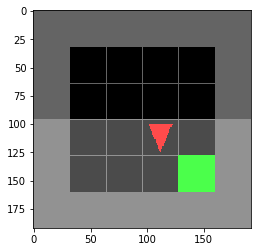

(192, 192, 3)


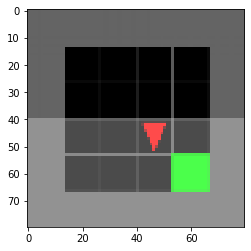

In [12]:
from gym_minigrid.envs import EmptyEnv


# env = EmptyEnv()
env = gym.make('MiniGrid-Empty-Random-6x6-v0')
k = env.render(mode='rgb_array')
plt.imshow(env.render(mode='rgb_array'));plt.show()
print(k.shape)
plt.imshow(resize(k, (80,80), anti_aliasing=False))

### Optimization function

In [13]:
loss = nn.MSELoss()
loss_a = nn.MSELoss()
L_r_vec = []
L_m_vec = []
L_a_vec = []
# t_params = list(tnet.parameters()) + list(tnet2.parameters())
tw_params = list(tnet.parameters()) + list(tnet2.parameters()) + list(wnet.parameters())
# optimizer_t = optim.Adam(t_params, lr=25e-5)
# optimizer_w = optim.Adam(wnet.parameters(), lr=1e-5)
optimizer_tw = optim.Adam(tw_params, lr=50e-5)
optimizer_a = optim.Adam(anet.parameters(), lr=5e-5)

def optimize_model():
    if (len(memory) < BATCH_SIZE) or (not memory_win.is_ready()):
        return
    
    if(np.random.rand()>0.2): # winning samples
        transitions, bs = memory_win.sample(BATCH_SIZE)
        
    else: # intermediate samples
        transitions, bs = memory.sample(BATCH_SIZE)
        
    batch = Transition(*zip(*transitions))
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    nstate_batch = torch.cat(batch.next_state)
    action_max = anet(tnet(state_batch)).matmul(wnet.head.weight.data.view(-1,1)).max(1)[1]
    next_state_ests = anet_target(tnet(nstate_batch))[torch.arange(0, bs),action_max.squeeze(),:]
        
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
#     non_final_mask = torch.tensor(tuple(map(lambda d: not d, batch.done)), device=device, dtype=torch.uint8)
#     non_final_next_states = batch.next_state[non_final_mask]
#     non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                           batch.next_state)), device=device, dtype=torch.uint8)
#     non_final_next_states = torch.cat([s for s in batch.next_state
#                                                 if s is not None])
    
    
    
    
#     import pdb; pdb.set_trace()
#     if(i_episode<200):
        # Computing the reward loss L_r, reconstruction loss
    L_r = F.smooth_l1_loss(reward_batch, wnet(tnet(nstate_batch)).squeeze(1))
    L_a = loss_a(state_batch, tnet2(tnet(state_batch)))
#     import pdb; pdb.set_trace()
    L_r_vec.append(L_r.item())
    L_a_vec.append(L_a.item())
    L_ra = L_a + L_r
    optimizer_tw.zero_grad()
    L_ra.backward()
    optimizer_tw.step()
    
    # Optimize the model
#     optimizer_t.zero_grad()
#     L_a.backward()
#     optimizer_t.step()
#     optimizer_w.zero_grad()
#     L_r.backward()
#     optimizer_w.step()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
#     import pdb; pdb.set_trace()
    # Computing the SF loss
    U_observed = anet(tnet(state_batch))[torch.arange(0, bs),action_batch.squeeze(),:]
    U_estimated = tnet(state_batch) + GAMMA * next_state_ests
    
    L_m = loss(U_observed, U_estimated)
    L_m_vec.append(L_m.item())
    
    # Optimize the model
    optimizer_a.zero_grad()
    L_m.backward()
    optimizer_a.step()

### Evaluation function

In [14]:
env_test = gym.make('MiniGrid-Empty-Random-5x5-v0')
def evaluate(no_seeds=10):
    r_vec = []
    for i in range(no_seeds):
        env_test.seed(i)
        env_test.reset()
        Rt = 0
        for timesteps in count():
            # choose greedy action
            action = select_action(tnet(get_screen(env_test)), wnet.head.weight.data.view(-1,1), greedy=True)
            _, R, done, _ = env_test.step(action.item())
            Rt = R + Rt
            if(done):
                r_vec.append(R)
                break
                
    return np.mean(r_vec), np.std(r_vec) 

### Main code

In [15]:
# Initializations: Line 1
num_episodes = 100 # CHANGE
n_actions = 3
R_eps = []
ed = []; eps_vec = [];
actions = []
eval_r_mean = []; eval_r_std = []
EVAL_INTERVAL = 500

#Setting seeds
torch.manual_seed(0); np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
global i_episode
for i_episode in tqdm(range(num_episodes)): # Line 2
    if(i_episode>1):
#         print('episode: {}/{}, time={}, reward={}, eps={}'.format(i_episode, num_episodes, ed[-1], R, eps_threshold))
        pass
    R = 0
    
    # Initialize the environment and state: Line 3
#     env.seed(0)
    env.reset() # <TODO: random initial location>
    state = get_screen(env)
    
    for t in count(): # Line 4
#         print(t, action)
        
        # Find abstracted states: Line 5
        phi = tnet(state)
        
        # Select an action: Line 6
        action = select_action(phi, wnet.head.weight.data.view(-1,1))
        actions.append(action.item())
        
        # Perform an action: Line 7
        _, reward, done, _ = env.step(action.item())
        reward = np.array(reward)>0
        R = R + reward
        reward = torch.tensor([reward], device=device).float()
        next_state = get_screen(env)
        
        # Store the transition in memory: Line 8
        if(reward==0):
            memory.push(state, action, next_state, reward, done)
        else:
            memory_win.push(state, action, next_state, reward, done)
            
        # Move to the next state
        state = next_state

        # Lines 9 - 11
        optimize_model() # TODO
        
        # Additional tracking
        if done:
            ed.append(t+1)
            R_eps.append(R)
            eps_vec.append(eps_threshold)
            break
            
    if i_episode % TARGET_UPDATE == 0:
        anet_target.load_state_dict(anet.state_dict())
        
    if i_episode % EVAL_INTERVAL == 0:
        r_mean, r_std = evaluate()
        eval_r_mean.append(r_mean)
        eval_r_std.append(r_std)

100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


Text(0.5, 1.0, 'evaluation rewards as training progresses')

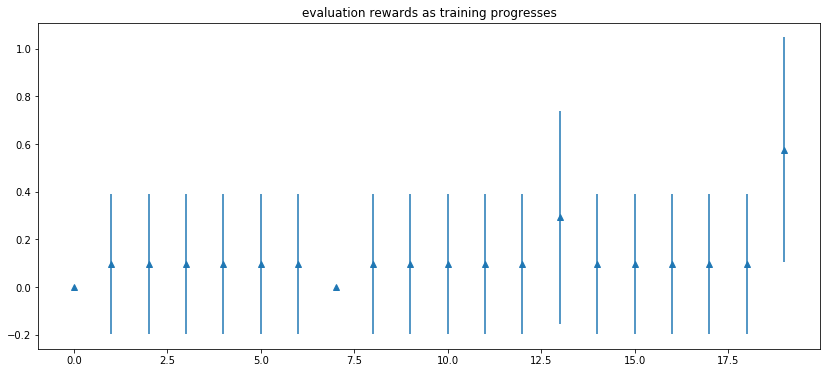

In [13]:
plt.figure(figsize=(14,6))
plt.errorbar(np.arange(len(eval_r_mean)), eval_r_mean, eval_r_std, linestyle='None', marker='^')
plt.title('evaluation rewards as training progresses')

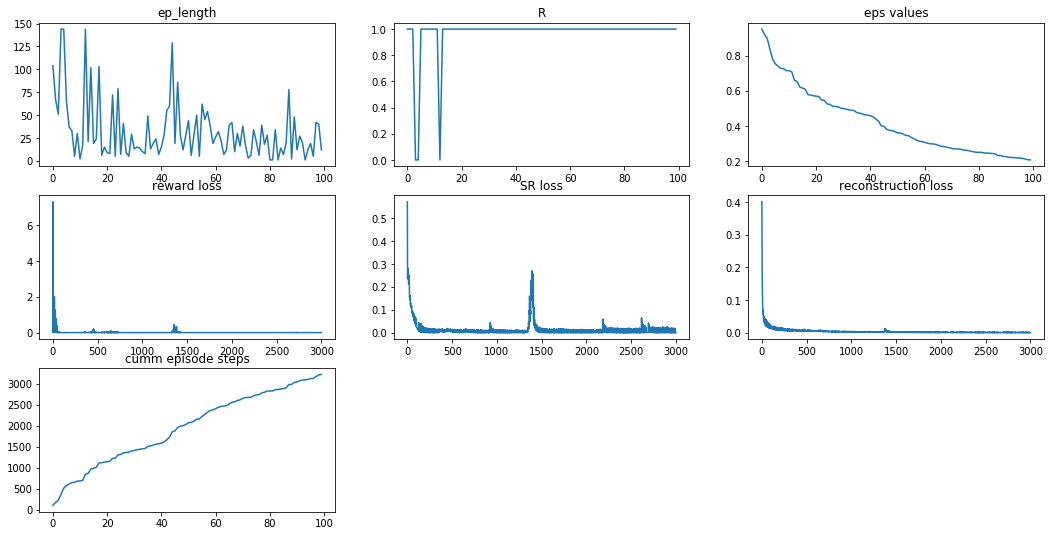

number of wins:  97


In [16]:
def visualize_results():
    plt.figure(figsize=(18,9))
    plt.subplot(3,3,1); plt.plot(ed); plt.title('ep_length');
    plt.subplot(3,3,2); plt.plot(R_eps); plt.title('R'); 
    plt.subplot(3,3,3); plt.plot(eps_vec); plt.title('eps values'); 
    plt.subplot(3,3,4); plt.plot(L_r_vec[:]); plt.title('reward loss'); 
    plt.subplot(3,3,5); plt.plot(L_m_vec[:]); plt.title('SR loss'); 
    plt.subplot(3,3,6); plt.plot(L_a_vec[:]); plt.title('reconstruction loss'); 
    plt.subplot(3,3,7); plt.plot(np.cumsum(ed)); plt.title('cumm episode steps'); plt.show()

visualize_results()
print('number of wins: ', len(memory_win))

Text(0.5, 1.0, 'sanity check for actions')

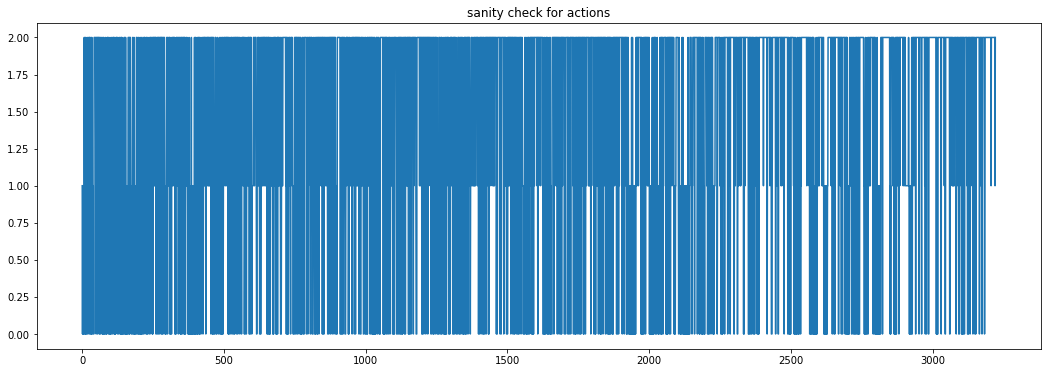

In [17]:
plt.figure(figsize=(18,6))
plt.plot(actions); plt.title('sanity check for actions')

### Sanity checks

In [18]:

def visualize_samples_from_memory(memory, batchsize=4):
    k = memory.sample(4)
    plt.figure(figsize=(6,6))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(k[0][i].next_state.cpu().squeeze(0).permute(1,2,0).numpy())
        plt.title('R = {}'.format(k[0][i].reward.cpu().numpy()[0]))
    plt.show()
    
# visualize_samples_from_memory(memory)
# visualize_samples_from_memory(memory_win)

In [19]:
def find_qvalues(i):
    state_matrix = torch.load('state_matrix_3x3.pt')
#     print(anet(tnet(state_matrix[i,:,:,:].unsqueeze(0))).shape)
    print(anet(tnet(state_matrix[i,:,:,:].unsqueeze(0))).squeeze(0).matmul(wnet.head.weight.data.squeeze(0)))

find_qvalues(23)

tensor([0.0538, 0.0382, 0.1363], device='cuda:0', grad_fn=<MvBackward>)


iteration: 0, action: 2, R: 0, i: 0
tensor([[0.0337]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 1, action: 2, R: 0, i: 1
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 2, action: 2, R: 0, i: 2
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 3, action: 2, R: 0, i: 3
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 4, action: 2, R: 0, i: 4
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 5, action: 2, R: 0, i: 5
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 6, action: 2, R: 0, i: 6
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 7, action: 2, R: 0, i: 7
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 8, action: 2, R: 0, i: 8
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 9, action: 2, R: 0, i: 9
tensor([[0.0808]], device='cuda:0', grad_fn=<AddmmBackward>)
iteration: 10, action: 2, R: 0

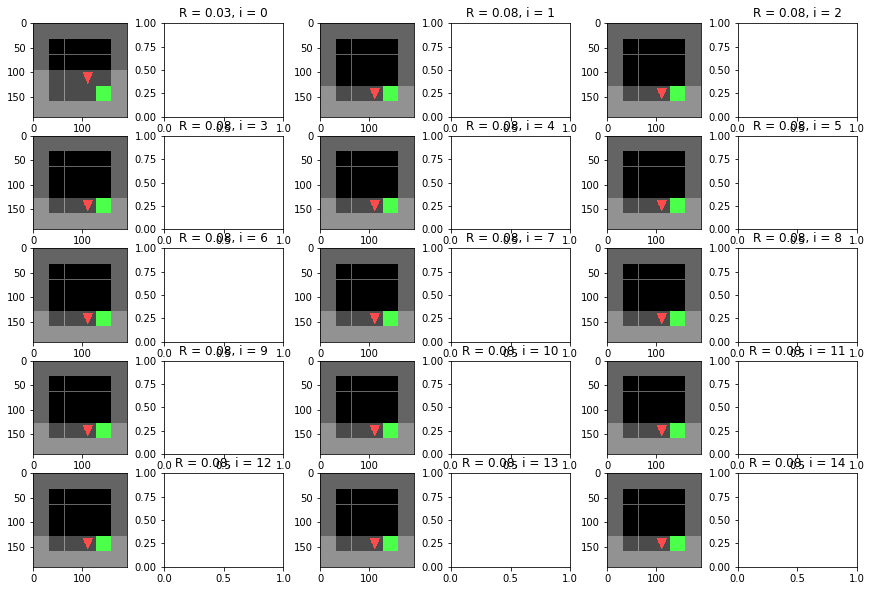

In [23]:
def sanity_check():
#     env.seed(0)
    env.reset()
    eps_threshold = 1
    iterations = 15
    plt.figure(figsize=(15,10))
    R = 0
    for i in range(iterations):
        plt.subplot(5,6,2*i+1)
        plt.imshow(env.render(mode='rgb_array')); 
        plt.subplot(5,6,2*i+2)
#         plt.imshow(tnet2(tnet(get_screen(env))).cpu().squeeze(0).permute(1,2,0).detach().numpy());
        state = get_screen(env)
        plt.title('R = {0:.2f}, i = {1:.0f}'.format(wnet(tnet(state)).detach().cpu().numpy()[0,0], i))
        action = select_action(tnet(state), wnet.head.weight.data.view(-1,1), greedy=True)
#         action = np.random.randint(low=0, high=3)
        print('iteration: {}, action: {}, R: {}, i: {}'.format(i, action.item(), R, i))
        print(wnet(tnet(state)))
#         print(anet(tnet(state)).matmul(wnet.head.weight.data.view(-1,1)).detach().cpu().numpy())
        _, R, done, _ = env.step(action)
        if(done):
            break
    plt.show()
sanity_check()

In [19]:
def reward_sanity_check():
    state_matrix = torch.load('state_matrix_3x3.pt')
    reward_est = wnet(tnet(state_matrix)).squeeze(1)
    reward_est = reward_est.detach().cpu().numpy()
    error_0 = np.mean(np.abs(reward_est[:32]-np.zeros(32)))
    error_1 = np.mean(np.abs(reward_est[34:]-np.ones(2)))
    print('0-reward error: {0:2.3f}, 1-reward error: {1:2.3f}'.format(error_0, error_1))
    print('reward estimates: ', reward_est)
    
reward_sanity_check()

0-reward error: 0.026, 1-reward error: 0.312
reward estimates:  [-0.03087422 -0.03422046 -0.02197054 -0.02118503 -0.01689094 -0.03471942
 -0.03319799 -0.02108056 -0.00993145 -0.02892936 -0.04449106 -0.01511486
 -0.03044539 -0.01705642 -0.01930817 -0.03662305 -0.01401579 -0.01170222
 -0.03573173 -0.03432285 -0.00223889 -0.01730607 -0.04415966 -0.03090301
 -0.02974733 -0.01207882 -0.01558491 -0.04810665 -0.01945589 -0.01084753
 -0.03587505 -0.04733937  0.23034579  0.2858184   0.66643924  0.7096385 ]


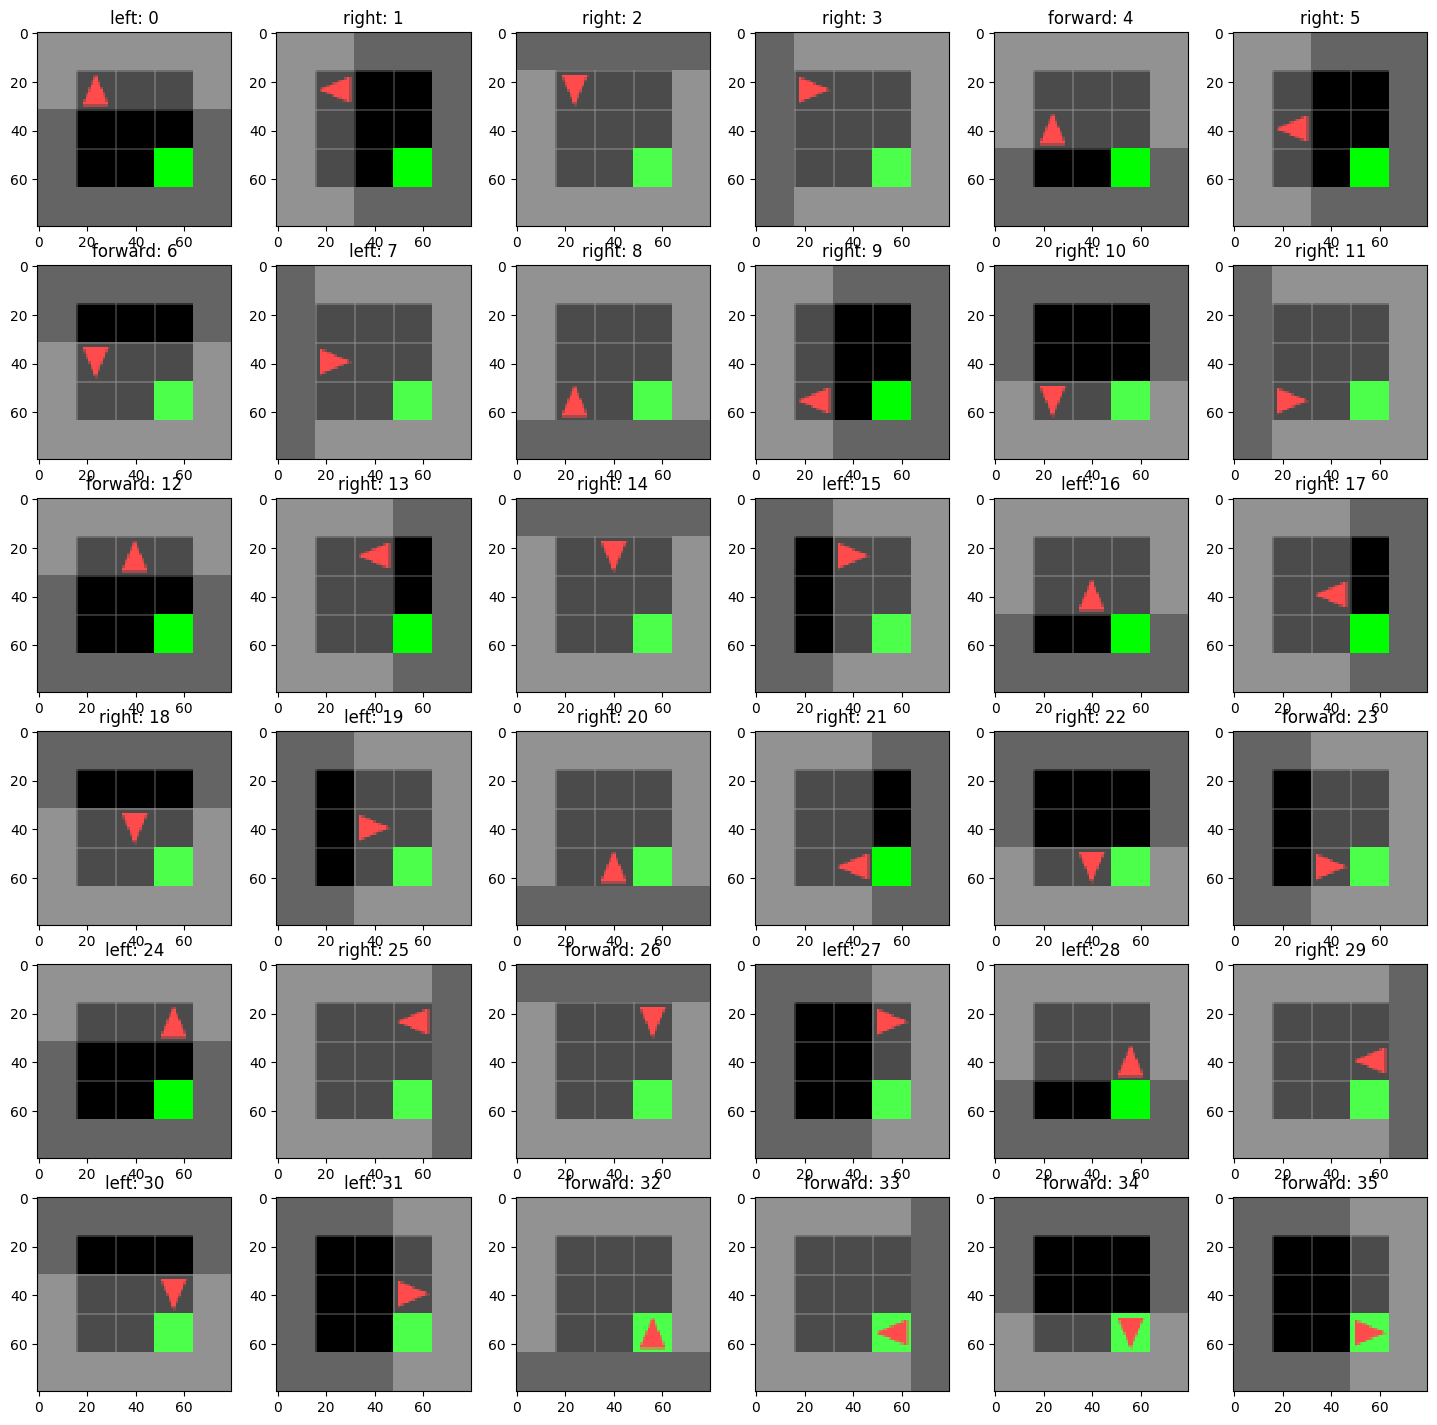

In [20]:
def learnt_policy():
    mapping = ['left', 'right', 'forward']
    state_matrix = torch.load('state_matrix_3x3.pt')
    plt.figure(figsize=(18,18), dpi=100)
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.imshow(state_matrix.detach().cpu()[i,:,:,:].squeeze(0).permute(1,2,0).numpy())
        plt.title(mapping[select_action(tnet(state_matrix[i,:,:,:].unsqueeze(0)), wnet.head.weight.data.view(-1,1)).item()] + ': ' + str(i))
    plt.show()
    
learnt_policy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

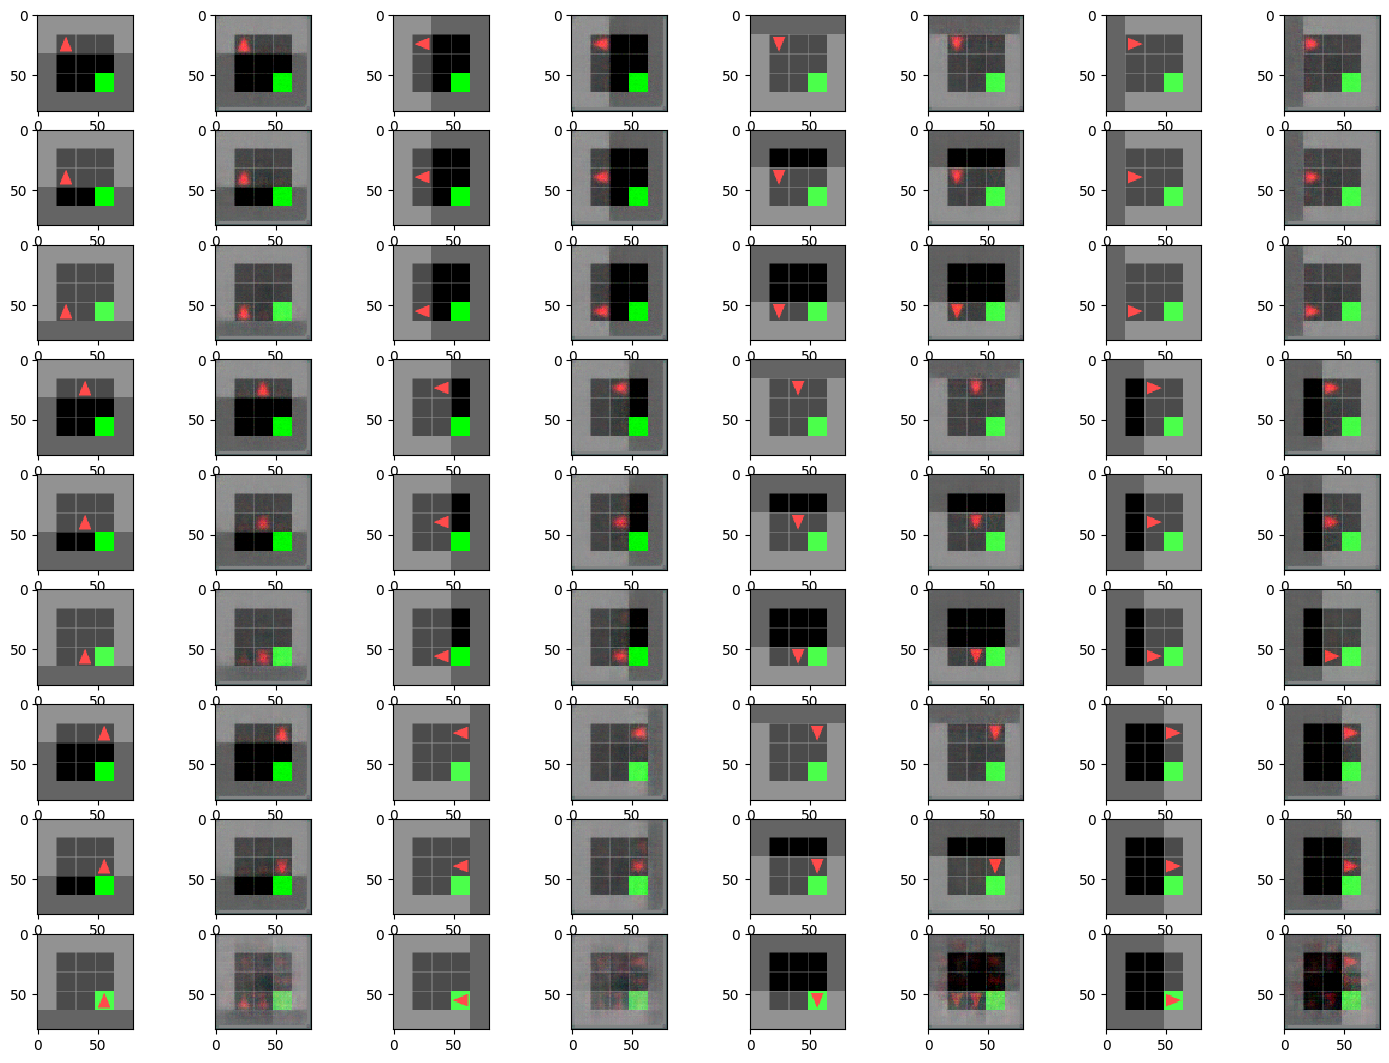

In [21]:
# warnings.simplefilter("once")
def reconstruction_sanity_check():
    state_matrix = torch.load('state_matrix_3x3.pt')
    state_r = tnet2(tnet(state_matrix))
    plt.figure(figsize=(18,18), dpi=100)
    for i in range(36):
        plt.subplot(12,8,2*i+1)
        plt.imshow(state_matrix.detach().cpu()[i,:,:,:].squeeze(0).permute(1,2,0).numpy())
        plt.subplot(12,8,2*i+2)
        plt.imshow(state_r.detach().cpu()[i,:,:,:].squeeze(0).permute(1,2,0).numpy())
    plt.show()
    
reconstruction_sanity_check()

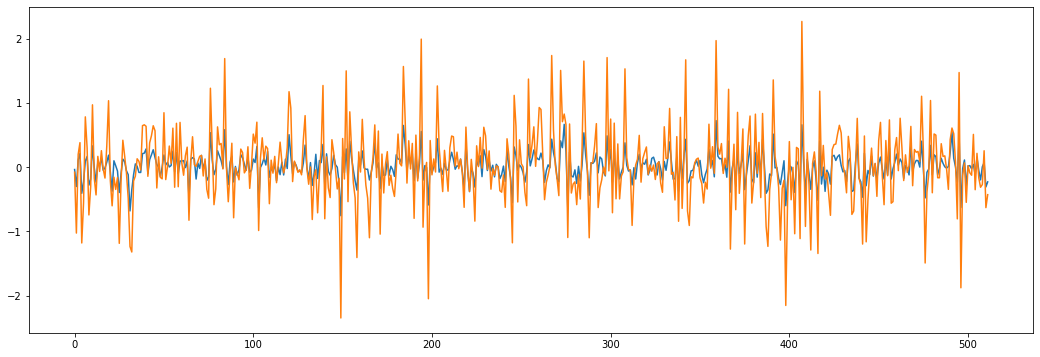

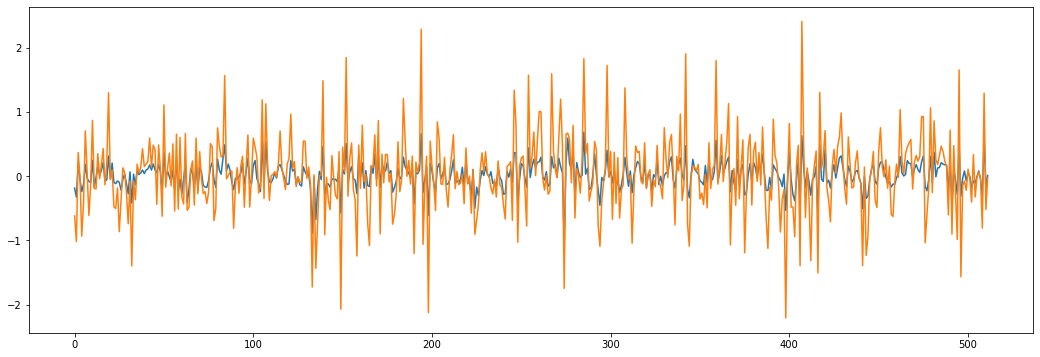

error1: 0.2918087840080261, error2: 0.30471229553222656


In [22]:

def SR_sanity_check(): # this needs to fail, would be correct for incorrect implementations
    
    state_matrix = torch.load('state_matrix_3x3.pt')
    
    phi = tnet(state_matrix)
    exp1 = phi[23,:].detach().cpu().numpy()
    exp2 = phi[30,:].detach().cpu().numpy()
    
    M = anet(tnet(state_matrix))
    est1 = M[23,2,:].detach().cpu().numpy()
    est2 = M[30,2,:].detach().cpu().numpy()
    
    plt.figure(figsize=(18,6))
    plt.plot(exp1);
    plt.plot(est1); plt.show()
    plt.figure(figsize=(18,6))
    plt.plot(exp2);
    plt.plot(est2); plt.show()
    
    print('error1: {}, error2: {}'.format(np.mean(np.abs(exp1-est1)),np.mean(np.abs(exp2-est2))))
    
    pass

SR_sanity_check()

In [23]:
def save_models(label="tmp"):
    torch.save(tnet.state_dict(), label+"tnet"+".pt")
    torch.save(tnet2.state_dict(), label+"tnet2"+".pt")
    torch.save(anet.state_dict(), label+"anet"+".pt")
    torch.save(wnet.state_dict(), label+"wnet"+".pt")
    
# save_models()